In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# 2.Load Dataset
data = pd.read_csv("viettri_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,44,17,29,2,9,4
1,3/2/2019,65,37,27,4,12,4
2,3/3/2019,81,38,2,1,1,2
3,3/4/2019,51,24,21,4,8,1
4,3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...,...
1915,5/28/2024,38,24,35,1,15,5
1916,5/29/2024,38,17,41,7,15,10
1917,5/30/2024,28,8,11,1,15,1
1918,5/31/2024,12,12,16,1,16,7


In [3]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1920 non-null   object
 1   pm25    1920 non-null   int64 
 2   pm10    1920 non-null   int64 
 3   o3      1920 non-null   int64 
 4   no2     1920 non-null   int64 
 5   so2     1920 non-null   int64 
 6   co      1920 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,42.395313,22.470833,17.391667,7.528125,9.497917,3.961979
std,31.665288,16.124166,12.907283,4.971229,6.526731,2.516048
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,19.000000,10.000000,8.750000,3.000000,4.000000,2.000000
50%,35.000000,20.000000,15.000000,7.000000,9.000000,4.000000
75%,59.000000,32.000000,24.000000,11.000000,14.000000,6.000000
max,178.000000,94.000000,114.000000,35.000000,27.000000,22.000000


In [4]:
#Chọn thuộc tính
data = data[['pm25','pm10']]
data = data.dropna() 
data = data.reset_index(drop=True) 
data

,pm25,pm10
0,44,17
1,65,37
2,81,38
3,51,24
4,43,7
...,...,...
1915,38,24
1916,38,17
1917,28,8
1918,12,12


<Axes: >

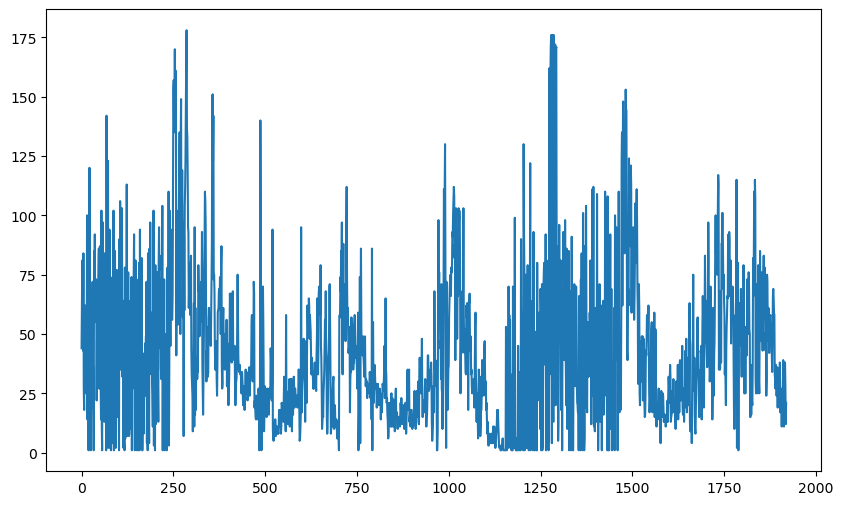

In [5]:
data['pm25'].plot(figsize=(10,6))

In [6]:
# Split the data into training, testing
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [7]:
# 3. Quá trình Training
model = VAR(train_data)
model_fitted = model.fit()

In [8]:
# 4. Quá trình testing 
# Dự đoán cho cả 'pm25' và 'o3'
y_pred = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=len(test_data))

In [9]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index = data.index[-1]
next_30_days_index = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)

# Dự đoán cho 30 ngày tiếp theo
y_next_30_days = model_fitted.forecast(model_fitted.endog[-model_fitted.k_ar:], steps=90)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 90 days:')
print(y_next_30_days)


Predicted closing prices for the next 90 days:
[[52.59936456 24.91385445]
 [48.99607706 23.81102564]
 [46.81977755 22.91333264]
 [45.25933631 22.25470364]
 [44.12457581 21.7749305 ]
 [43.29850686 21.42562743]
 [42.69710892 21.1713241 ]
 [42.25927435 20.98618401]
 [41.94051836 20.85139677]
 [41.70845496 20.75326784]
 [41.53950622 20.68182719]
 [41.41650674 20.62981637]
 [41.32695963 20.59195101]
 [41.26176679 20.56438396]
 [41.21430455 20.54431436]
 [41.17975069 20.52970313]
 [41.15459451 20.51906573]
 [41.13628009 20.51132141]
 [41.12294667 20.50568332]
 [41.11323957 20.50157863]
 [41.10617252 20.4985903 ]
 [41.10102751 20.49641471]
 [41.09728179 20.49483082]
 [41.09455481 20.49367771]
 [41.09256948 20.49283821]
 [41.09112411 20.49222702]
 [41.09007184 20.49178207]
 [41.08930575 20.49145812]
 [41.08874802 20.49122229]
 [41.08834198 20.49105059]
 [41.08804637 20.49092559]
 [41.08783115 20.49083458]
 [41.08767447 20.49076833]
 [41.0875604  20.4907201 ]
 [41.08747736 20.49068498]
 [41.087

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính RMSE
rmse = np.sqrt(mean_squared_error(test_data['pm25'], y_pred[:, 0]))
print('Testing RMSE:', rmse)

# Tính MAE
mae = mean_absolute_error(test_data['pm25'], y_pred[:, 0])
print('\nTesting MAE:', mae)

# Tính MAPE
mape = np.mean(np.abs((test_data['pm25'] - y_pred[:, 0]) / test_data['pm25'])) * 100
print('\nTesting MAPE:', mape)


Testing RMSE: 29.318148647511496

Testing MAE: 22.948845419993912

Testing MAPE: 163.10146692495476


In [11]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

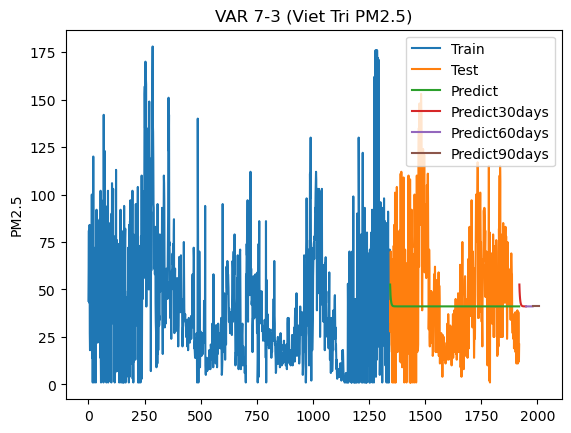

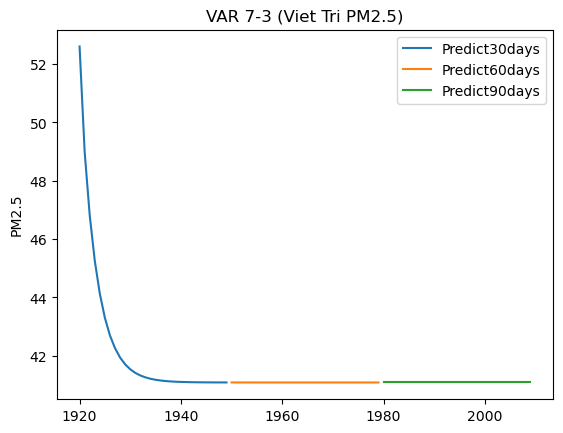

In [12]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['pm25'])
plt.plot(test_data.index, test_data['pm25'])
plt.plot(test_data.index, y_pred[:, 0])


last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_30_days[0:30][:, 0])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_30_days[30:60][:, 0])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_30_days[60:90][:, 0])
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('VAR 7-3 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()


#DỰ đians 90 ngày
last_data = pd.RangeIndex(start=last_index+1, stop=last_index+31, step=1)
plt.plot(last_data,y_next_30_days[0:30][:, 0])

last_data = pd.RangeIndex(start=last_index+31, stop=last_index+61, step=1)
plt.plot(last_data,y_next_30_days[30:60][:, 0])

last_data = pd.RangeIndex(start=last_index+61, stop=last_index+91, step=1)
plt.plot(last_data,y_next_30_days[60:90][:, 0])
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('VAR 7-3 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

